In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class Layer():
    def __init__(self, input_size: int, output_size: int):
        """Number of input neurons"""
        self.input_size: int = input_size
        """Number of output neurons"""
        self.output_size: int = output_size

        """shape: output_size x input_size (matrix)"""
        self.weights = np.random.randn(output_size, input_size)
        """shape: output_size x 1 (vector)"""
        self.bias = np.random.randn(output_size, 1)

    def forward(self, inputs) -> np.ndarray:
        """Expects input to be a numpy array of size input_size x 1 and 
        returns a numpy array of size output_size x 1"""
        self.inputs = inputs
        return np.dot(self.weights, inputs) + self.bias

    def backward(self, output_gradient, learning_rate):
        """Gradient of error wrt weights = gradient of error wrt output * input transposed"""
        weights_gradient = np.dot(output_gradient, self.inputs.T)

        """Gradient of error wrt bias = gradient of error wrt output"""
        bias_gradient = output_gradient

        """Gradient of error wrt inputs = weights transposed * gradient of error wrt output"""
        input_gradient = np.dot(self.weights.T, output_gradient)

        """Update weights and bias"""
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * bias_gradient
        return input_gradient

In [3]:
class SigmoidActivationLayer():
    def __init__(self):
        """This layer takes in inputs and applies an activation function to them"""
        """so the input and output size are the same"""
        self.sigmoid: Callable = lambda x: 1/(1 + np.exp(-x))
        self.sigmoid_derivative: Callable = lambda x: self.sigmoid(x) * (1 - self.sigmoid(x))

    def forward(self, inputs) -> np.ndarray:
        self.inputs = inputs
        return self.sigmoid(inputs)

    def backward(self, output_gradient, _):
        """Gradient of error wrt inputs = gradient of error wrt output '*' activation derivative of inputs"""
        """ '*' is element-wise multiplication """
        return np.multiply(output_gradient, self.sigmoid_derivative(self.inputs))

In [4]:
def mse(y_true, y_pred):
    return (np.power(y_true - y_pred, 2)) / 2


def mse_derivative(y_true, y_pred):
    return y_pred - y_true

In [5]:
def train(epochs, learning_rate, train_df_xs, train_df_ys, network):
    for _ in range(epochs):
        for x, y in zip(train_df_xs, train_df_ys):
            output = x
            for layer in network:
                output = layer.forward(output)

            grad = mse_derivative(y, output)

            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

In [6]:
def test(test_df_xs, test_df_ys, network, network_name, outputs, df_i):
    predictions = []
    error = 0
    for x, y in zip(test_df_xs, test_df_ys):
        output = x
        for layer in network:
            output = layer.forward(output)

        predictions.append(output.item())
        error += mse(y, output)
    error /= len(test_df_xs)
    outputs[network_name][df_i]["x"] = test_df_xs.reshape(
        test_df_xs.shape[0]).tolist()
    outputs[network_name][df_i]["y"].extend(predictions)
    outputs[network_name][df_i]["error"] = error.item()

In [7]:
def addLabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 2), ha='center')

In [8]:
"""Reading the training data"""
train_dfs: list[pd.DataFrame] = []
for i in range(1, 11):
    train_dfs.append(pd.read_csv(f"../data/sample{i}.csv", header=None))

"""Reading the test data"""
test_df: pd.DataFrame = pd.read_csv("../data/test.csv", header=None)

In [9]:
"""Dividing the training data into X and y"""
train_dfs_xs: list[np.ndarray] = []
train_dfs_ys: list[np.ndarray] = []
for train_df in train_dfs:
    trdx = train_df.iloc[:, :-1].to_numpy()
    trdy = train_df.iloc[:, -1].to_numpy()
    trdy = trdy.reshape(trdy.shape[0], 1)
    train_dfs_xs.append(trdx.reshape(trdx.shape[0], trdx.shape[1], 1))
    train_dfs_ys.append(trdy.reshape(trdy.shape[0], trdy.shape[1], 1))

"""Dividing the test data into X and y"""
test_df_xs: np.ndarray = test_df.iloc[:, :-1].to_numpy()
test_df_xs = test_df_xs.reshape(
    test_df_xs.shape[0], test_df_xs.shape[1], 1)
test_df_ys: np.ndarray = test_df.iloc[:, -1].to_numpy()
test_df_ys = test_df_ys.reshape(test_df_ys.shape[0], 1, 1)

In [10]:
slp = [Layer(1, 1)]
mlp_2 = [Layer(1, 2), SigmoidActivationLayer(), Layer(2, 1)]
mlp_3 = [Layer(1, 3), SigmoidActivationLayer(), Layer(3, 1)]
mlp_5 = [Layer(1, 5), SigmoidActivationLayer(), Layer(5, 1)]
mlp_10 = [Layer(1, 10), SigmoidActivationLayer(), Layer(10, 1)]

network_names = ["slp", "mlp_2", "mlp_3", "mlp_5", "mlp_10"]
networks = [slp, mlp_2, mlp_3, mlp_5, mlp_10]

epochs = 4000
learning_rate = 0.001
outputs = {name: {i+1: {"x": [], "y": [], "error": 0.0}
                    for i in range(10)} for name in network_names}

In [11]:
for df_i, (train_df_xs, train_df_ys) in enumerate(zip(train_dfs_xs, train_dfs_ys)):

    for i, (network, network_name) in enumerate(zip(networks, network_names)):
        # Training
        train(epochs, learning_rate, train_df_xs, train_df_ys, network)

        # Testing
        test(test_df_xs, test_df_ys, network,
                network_name, outputs, df_i + 1)

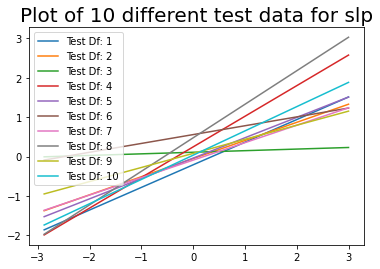

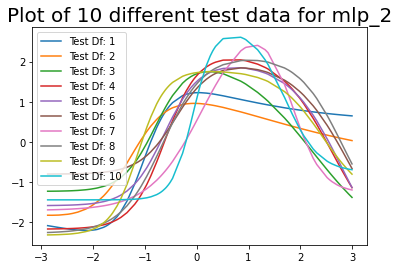

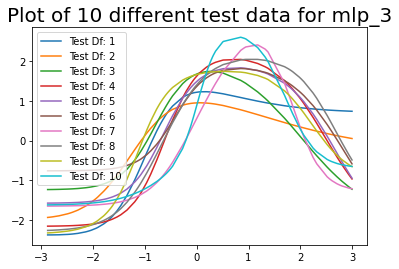

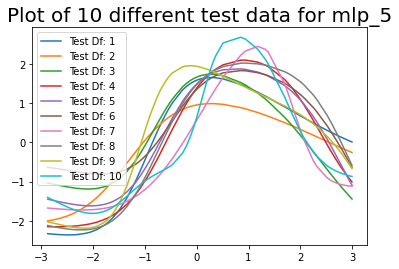

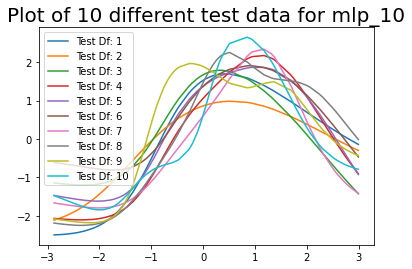

In [12]:
mse_values_by_network = {network_name: []
                            for network_name in network_names}

for name, df_indexes in outputs.items():
    for df_index, df_data in df_indexes.items():
        mse_values_by_network[name].append(df_data["error"])
        plt.title(
            f"Plot of 10 different test data for {name}", fontsize=20)
        plt.plot(df_data["x"], df_data["y"], label=f"Test Df: {df_index}")
        plt.legend(loc='upper left')
    plt.show()

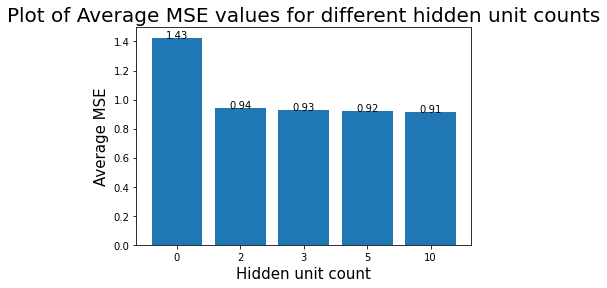

In [13]:
mean_squared_errors = [np.mean(mses)
                        for mses in mse_values_by_network.values()]
plt.title(f"Plot of Average MSE values for different hidden unit counts", fontsize=20)
plt.bar(range(5), mean_squared_errors)
plt.xticks(range(5), [0, 2, 3, 5, 10])
plt.xlabel('Hidden unit count', fontsize=15)
plt.ylabel('Average MSE', fontsize=15)
addLabels([0, 2, 3, 5, 10], mean_squared_errors)
plt.show()